Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Combined Tweets Classifier Accuracy: 0.8126112382405288
Combined Tweets Classifier Report:
               precision    recall  f1-score   support

           0       0.86      0.68      0.76      3368
           1       0.79      0.91      0.85      4498

    accuracy                           0.81      7866
   macro avg       0.82      0.80      0.80      7866
weighted avg       0.82      0.81      0.81      7866



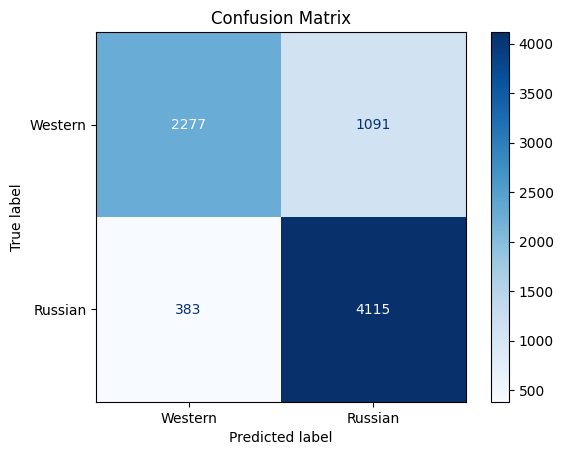

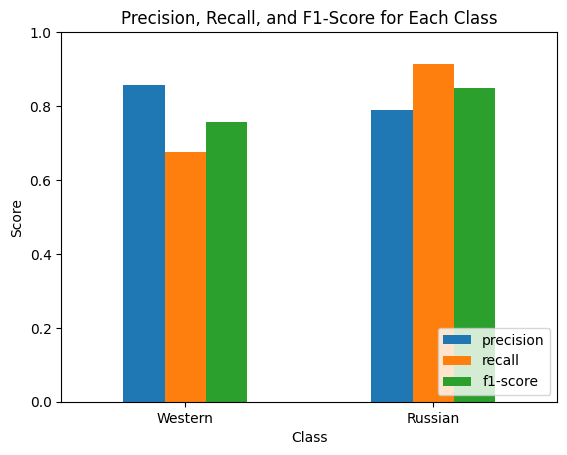

In [2]:
# Install the necessary packages if they are not already installed
%pip install nltk matplotlib seaborn

import re
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Ensure necessary NLTK data is downloaded
nltk.download('stopwords')
from nltk.corpus import stopwords

# Load the combined CSV file
df_combined = pd.read_csv('merged_df.csv')

# tweets are in a column named 'tweet' and labels are in a column named 'Russian'
tweets_combined = df_combined['tweet'].tolist()
labels_combined = df_combined['Russian'].tolist()

# Function to preprocess the tweets
def preprocess_tweet(tweet):
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\@\w+|\#','', tweet)
    tweet = tweet.lower()
    tweet = re.sub(r'[^\w\s]', '', tweet)
    return tweet

# Preprocess all tweets
tweets_combined = [preprocess_tweet(tweet) for tweet in tweets_combined]

# Split the combined data into training and testing sets
X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(tweets_combined, labels_combined, test_size=0.2, random_state=42)

# Initialize the TF-IDF vectorizer for combined data
vectorizer_comb = TfidfVectorizer(stop_words=stopwords.words('english') + stopwords.words('russian'))

# Fit and transform the training data, transform the testing data
X_train_comb_tfidf = vectorizer_comb.fit_transform(X_train_comb)
X_test_comb_tfidf = vectorizer_comb.transform(X_test_comb)

# Initialize the Logistic Regression model for combined data
model_comb = LogisticRegression()

# Train the model
model_comb.fit(X_train_comb_tfidf, y_train_comb)

# Predict the labels for the test set
y_pred_comb = model_comb.predict(X_test_comb_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test_comb, y_pred_comb)
report = classification_report(y_test_comb, y_pred_comb, output_dict=True)
print("Combined Tweets Classifier Accuracy:", accuracy)
print("Combined Tweets Classifier Report:\n", classification_report(y_test_comb, y_pred_comb))

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test_comb, y_pred_comb)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Western', 'Russian'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Extract metrics for each class
metrics_df = pd.DataFrame(report).transpose()

# Plot the precision, recall, and F1-score for each class
metrics_df[['precision', 'recall', 'f1-score']].iloc[:-3].plot(kind='bar')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(ticks=[0, 1], labels=['Western', 'Russian'], rotation=0)
plt.legend(loc='lower right')
plt.show()


Top 10 most frequent words:
the: 40484
of: 21740
co: 20225
https: 20197
to: 18930
in: 17426
and: 14000
is: 10094
that: 8407
russian: 8173
[[2307 1012]
 [ 364 4183]]


              precision    recall  f1-score   support

           0       0.86      0.70      0.77      3319
           1       0.81      0.92      0.86      4547

    accuracy                           0.83      7866
   macro avg       0.83      0.81      0.81      7866
weighted avg       0.83      0.83      0.82      7866



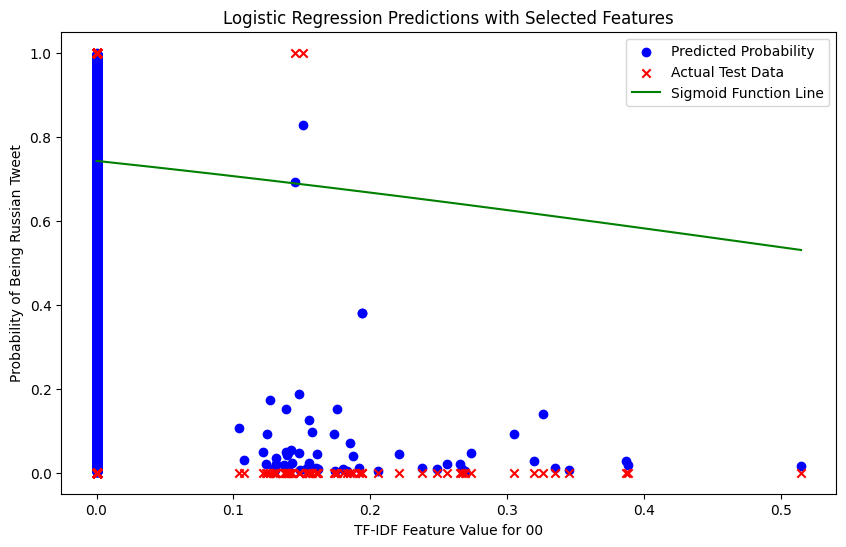

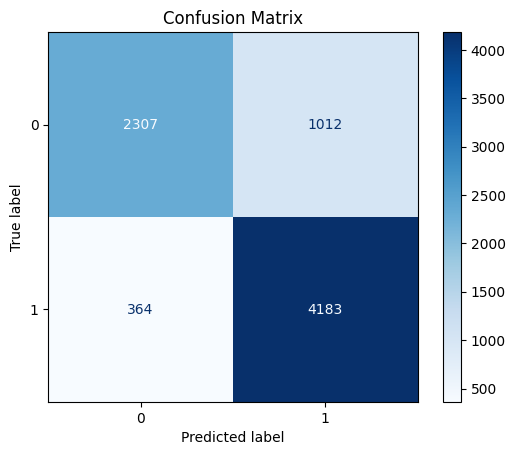

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Load the combined CSV file
df_combined = pd.read_csv('merged_df.csv')

# Extract tweets and labels
tweets_combined = df_combined['tweet']
labels_combined = df_combined['Russian']

# Convert labels to a numpy array
labels_combined = np.array(labels_combined)

# Vectorize the tweets using CountVectorizer to count word frequencies
count_vectorizer = CountVectorizer()
X_counts = count_vectorizer.fit_transform(tweets_combined)

# Get the word frequencies
word_freq = np.asarray(X_counts.sum(axis=0)).ravel()
words = count_vectorizer.get_feature_names_out()
word_freq_dict = dict(zip(words, word_freq))

# Find the top 10 most frequent words
sorted_word_freq = sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)
top_10_words = sorted_word_freq[:10]

print("Top 10 most frequent words:")
for word, freq in top_10_words:
    print(f"{word}: {freq}")

# Vectorize the tweets using TF-IDF(Term Frequency Inverse Document Frequency of records)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(tweets_combined)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, labels_combined, test_size=0.20, random_state=0)

# Create the logistic regression model
lrm = LogisticRegression(max_iter=1000)

# Train the model
lrm.fit(X_train, y_train)

# Make predictions to test the model
predicted = lrm.predict(X_test)

# Print confusion matrix and classification report
print(confusion_matrix(y_test, predicted))
print("\n")
print(classification_report(y_test, predicted))

# Define sigmoid function 
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# To visualize, we'll pick a feature from the TF-IDF features
# For simplicity, let's take the first feature
x_feat_index = 0
x_feat = vectorizer.get_feature_names_out()[x_feat_index]

# Extract the feature for visualization
X_test_feat = X_test[:, x_feat_index].toarray().ravel()

# To add a sigmoid function line over the scatter plot, we need a range of x values and compute the corresponding y values (probability)
x_range = np.linspace(X_test_feat.min(), X_test_feat.max(), 300)

# To compute y values, we need to create an input matrix that represents all features for these x values
# For simplicity and visualization purposes, we will fill other feature columns with their mean values from the test set
X_range_matrix = np.zeros((len(x_range), X_test.shape[1]))
X_range_matrix[:, x_feat_index] = x_range

# Compute z values (decision function) for this range
z_range = np.dot(X_range_matrix, lrm.coef_.T) + lrm.intercept_

# Apply the sigmoid function to these z values to get probabilities
y_range_proba = sigmoid(z_range).ravel()

# Making predictions on the test set with selected features
y_pred_proba = lrm.predict_proba(X_test)[:, 1]

# Visualizing the sigmoid function for the test data with selected features
plt.figure(figsize=(10, 6))
# Plotting sigmoid function based on selected features
plt.scatter(X_test_feat, y_pred_proba, color='blue', label='Predicted Probability')
# Plotting actual test data points
plt.scatter(X_test_feat, y_test, color='red', marker='x', label='Actual Test Data')

plt.plot(x_range, y_range_proba, color='green', label='Sigmoid Function Line')

plt.title('Logistic Regression Predictions with Selected Features')
plt.xlabel(f'TF-IDF Feature Value for {x_feat}')
plt.ylabel('Probability of Being Russian Tweet')
plt.legend()
plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lrm.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [12]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Load the combined CSV file
df_combined = pd.read_csv('merged_df.csv')

# Extract tweets
tweets_combined = df_combined['tweet']

# Define the list of common stop words to remove
#stop_words = set([
 #   'the', 'of', 'co', 'https', 'to', 'in', 'and', 'is', 'that'
#])

# Define a list of common stop words to remove
stop_words = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves',
    'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them',
    'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am',
    'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did',
    'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by',
    'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above',
    'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then',
    'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most',
    'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't',
    'can', 'will', 'just', 'don', 'should', 'now', 'the', 'of', 'co', 'https', 'to', 'in', 'and', 'is', 'that'
])

# Convert the stop words set to a list
stop_words_list = list(stop_words)

# Define a CountVectorizer with specified stop words
count_vectorizer = CountVectorizer(stop_words=stop_words_list)

# Transform the tweets into a document-term matrix
X_counts = count_vectorizer.fit_transform(tweets_combined)

# Sum the frequencies of each word
word_freq = X_counts.sum(axis=0)

# Get the feature names (words)
words = count_vectorizer.get_feature_names_out()

# Create a dictionary of word frequencies
word_freq_dict = dict(zip(words, word_freq.tolist()[0]))

# Sort the word frequencies in descending order
sorted_word_freq = sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)

# Take the top 10 most frequent words
top_10_words = sorted_word_freq[:10]

# Print the top 10 most frequent words
print("Top 10 most frequent words (excluding common stop words):")
for word, freq in top_10_words:
    print(f"{word}: {freq}")

Top 10 most frequent words (excluding common stop words):
russian: 8173
ukraine: 7864
russia: 5006
ukrainian: 3744
forces: 2498
war: 2215
people: 2113
us: 2104
military: 2069
one: 1647
